## Voorspelling watertemperatuur bij reservoirs

### Data analyse

Via eerder geschreven scripts (data.py) kan de data opgehaald worden. Het betreft hier **gemiddelde dagwaarden** voor de periode van 01-01-2015 tot heden. De resultaten worden als een groot csv bestand weggeschreven in data/combined_data.

De kolommen staan voor de volgende locaties van sensormetingen;

| tag | locatie | omschrijving |
|------|------|------|
| 1N305KM01TIT001 |  Nieuwegein Inname - Ruwwater |	Inname Lekkanaal |
| 1N625SW03TT001  |  Nieuwegein Snelfiltratie WRK I (voor snelfiltratie) | WBC voor snelfiltratie |
| 1N625SW02TT001  |  Nieuwegein Snelfiltratie WRK II (voor snelfiltratie) | WBC voor snelfiltratie |
| 1N315KM01TIT001 | Nieuwegein Transport - WRK I Filtraat | WBC na snelfiltratie |
| 1N315KM02TIT003 | Nieuwegein Transport - WRK II Filtraat | WBC na snelfiltratie |
| | | |
| 1Q325TB03TT151  | MIS Transport - WRK water Nieuwerkerkerstraat Lijnden | aftakking WRK II naar Havengebied |
| 1D325TA01TT001  | MIS Transport - WRK water Vogelenzang | Precieze locatie onbekend |
| T-WRK-Schiphol_STUW12 | MIS Transport WRK water stuw 12 | AWD voor infiltratie |
| | | |
| 1L635KM05TT002  | LDN Hardheidsreductie - onthard water afvoer West | Leiduin na ontharding |
| 1L635KM05TT001  | LDN Hardheidsreductie - onthard water afvoer Oost | Leiduin na ontharding |
| 1L315KM01TT001  | LDN Transport - Leiduin I Drinkwater | Leiduin drinkwater af pomp |
| | | |
| 3H325WT01TT001  | HLW Distributie - Haarlemmerweg Drinkwater | Pompstation Haarlemmerweg |
| 3A415DR01_Temp1 | AVW Drinkwaterreservoir 5 Ingaand HV085 | Pompstation Amstelveenseweg voor reservoir 5 |
| 3A415DR01_Temp2 | AVW Drinkwaterreservoir 5 Ingaand HV086 | Pompstation Amstelveenseweg voor reservoir 5 |
| 3A415DR01_Temp3 | AVW Drinkwaterreservoir 5 Uitgaand HV054 | Pompstation Amstelveenseweg na reservoir 5 |
| 3A415DR01_Temp4 | AVW Drinkwaterreservoir 1 Ingaand HV061 | Pompstation Amstelveenseweg voor reservoir 1 |
| 3A415DR01_Temp5 | AVW Drinkwaterreservoir 1 Ingaand HV062 | Pompstation Amstelveenseweg voor reservoir 1 |
| 3A415DR01_Temp6 | AVW Drinkwaterreservoir 1 Uitgaand HV038 | Pompstation Amstelveenseweg na reservoir 1 |

We lezen eerst de gemiddelde data per dag in om te kijken hoe de data eruit ziet.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import data
import datetime

%matplotlib inline

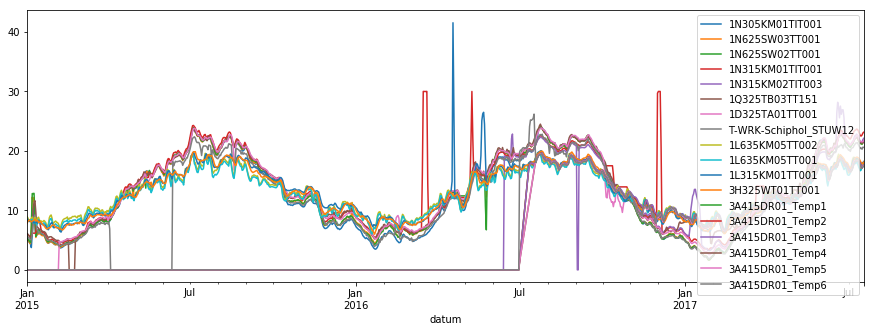

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H:%M:%S')
df = pd.read_csv('data/combined_data.csv', parse_dates=[1], date_parser=dateparser)
df = df.reset_index()
_ = df.plot(x='datum', y=data.TAGS[:], figsize=(15,5))

#### Prophet library toepassen

Een eerste mogelijkheid is het kijken naar de toepassing van een timeseries prediction algoritme dat verder geen afhankelijkheden bekijkt. We gebruiken hiervoor Prophet https://github.com/facebookincubator/prophet waar in het testproject van het Waternet datalab https://github.com/waternet/datalab_alg_prophet_test al code voor is geschreven.

We beginnen met de gewone toepassing van prophet en zoek een geschikte data serie aan de output kant.

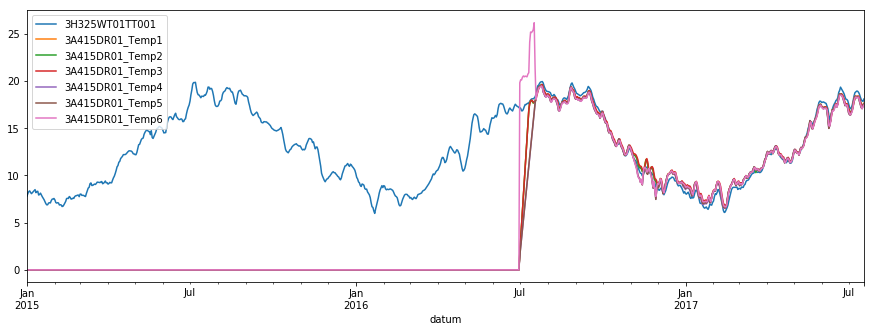

In [3]:
_ = df.plot(x='datum', y=data.TAGS_OUTPUT, figsize=(15,5))

De langst lopende temperatuurmeting is die van de Haarlemmerweg, deze gebruiken we voor de predictie via prophet.

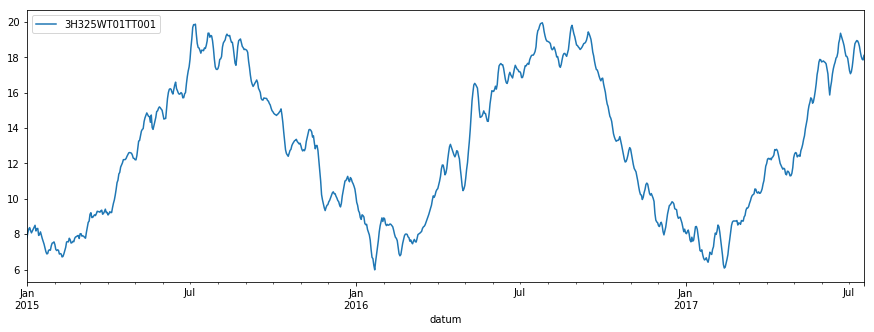

In [4]:
_ = df.plot(x='datum', y=['3H325WT01TT001'], figsize=(15,5))

We maken de data klaar voor Prophet waarbij een 'ds' kolom nodig is met datetimes en een 'y' kolom met outputs. We willen de data kunnen controleren dus we trainen met gegevens tot een x aantal dagen voor het laatste datapunt.

#### Aanname / aanpassing
Prophet verwacht vanuit de gebruikte statistische benadering de log van de data (stabiliseert de variantie) zie https://people.duke.edu/~rnau/411log.htm en https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf

In [33]:
VOORSPELLINGSPERIODE = 10 #dagen

df_hw = pd.DataFrame()
df_hw['ds'] = df['datum'][:-VOORSPELLINGSPERIODE]
df_hw['y'] = np.log(df['3H325WT01TT001'][:-VOORSPELLINGSPERIODE])

De volgende stap is om het model te trainen.

In [34]:
from fbprophet import Prophet
model = Prophet()
model.fit(df_hw)

En nu kunnen we een voorspelling doen. Laten we beginnen met een week vooruit te kijken.

In [35]:
future = model.make_future_dataframe(periods=VOORSPELLINGSPERIODE)

In [36]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
925,2017-07-14,2.968088,2.890249,3.048355
926,2017-07-15,2.974367,2.894011,3.053879
927,2017-07-16,2.980360,2.896355,3.056588
928,2017-07-17,2.983835,2.897256,3.064359
929,2017-07-18,2.986916,2.907155,3.065288


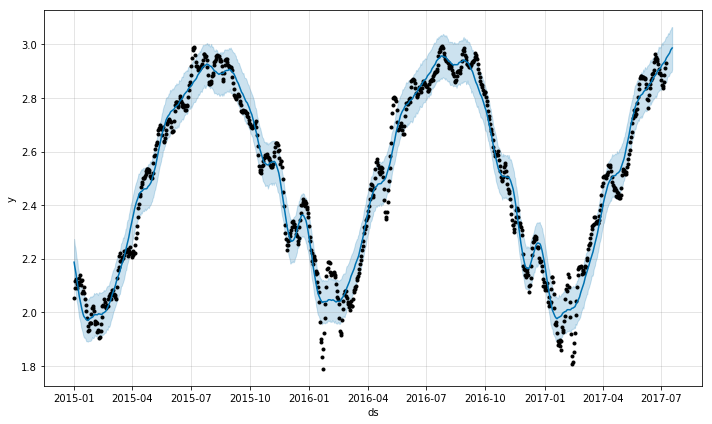

In [37]:
_ = model.plot(forecast)

Laten we eens kijken naar de voorspelde tegen de werkelijke waarde

In [10]:
X = df['datum'][-VOORSPELLINGSPERIODE:]
y_test = df['3H325WT01TT001'][-VOORSPELLINGSPERIODE:]
y_pred = np.exp(forecast['yhat'][-VOORSPELLINGSPERIODE:])
y_pred_lower = np.exp(forecast['yhat_lower'][-VOORSPELLINGSPERIODE:])
y_pred_upper = np.exp(forecast['yhat_upper'][-VOORSPELLINGSPERIODE:])

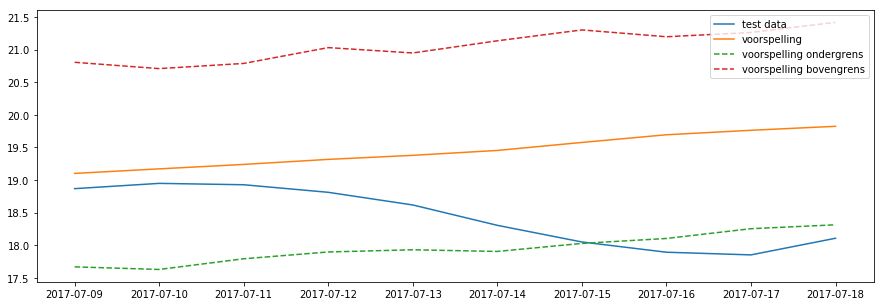

In [11]:
plt.figure(figsize=(15,5))
plt.plot(X, y_test, label='test data')
plt.plot(X, y_pred, label='voorspelling')
plt.plot(X, y_pred_lower, '--', label='voorspelling ondergrens')
plt.plot(X, y_pred_upper, '--', label='voorspelling bovengrens')
plt.legend()

Bij 10 dagen vooruit kijken duik je na een dag of 5 al onder de ondergrens. 

Dit is een momentopname dus laten we eens kijken hoe dat gaat als je het volgende doet;

* train het model 365 dagen
* vanaf dag 366, hertrain elke dag en doe een voorspelling voor 1, 7, 14 en 28 dagen

We doen dat in de onderstaande code en slaan de resultaten op in een dataframe. (Dit kan even duren waardoor er voor gekozen is om de onderstaande code buiten de notebook uit te voeren)

result = []

for i in range(366, df.shape[0]):
    print "Bezig met dag %d uit %d" % (i-366, df.shape[0] - 366)
    df_i = pd.DataFrame()
    df_i['ds'] = df['datum'][:i]
    df_i['y'] = np.log(df['3H325WT01TT001'][:i])
    model = Prophet()
    model.fit(df_i)
    future = model.make_future_dataframe(periods=28)
    forecast = model.predict(future)
    
    ds = forecast.iloc[-29]['ds']
    y = df.iloc[i]['3H325WT01TT001']
    y1 = np.exp(forecast.iloc[-28]['yhat'])
    y7 = np.exp(forecast.iloc[-21]['yhat'])
    y14 = np.exp(forecast.iloc[-14]['yhat'])    
    y28 = np.exp(forecast.iloc[-1]['yhat'])
    result.append([ds, y, y1,y7,y14,y28])
    
labels = ['datum', 'y', 'y_1d', 'y_1w', 'y_2w', 'y_4w']
df_voorspelling = pd.DataFrame.from_records(result, columns=labels)
df_voorspelling['datum'] = pd.to_datetime(df_voorspelling['datum'])  
df_voorspelling.to_csv('voorspelling.csv')

In [16]:
data = pd.read_csv('voorspelling_los.csv')
data.head()

,Unnamed: 0,datum,y,y_1d,y_1w,y_2w,y_4w
0,0,2016-01-01,9.801,9.696701,9.393689,9.100146,8.560386
1,1,2016-01-02,9.634,9.666768,9.363181,9.069127,8.530493
2,2,2016-01-03,9.328,9.610686,9.308288,9.015405,8.501145
3,3,2016-01-04,9.222,9.528962,9.226575,8.933784,8.427501
4,4,2016-01-05,8.938,9.467420,9.169039,8.880062,8.382560


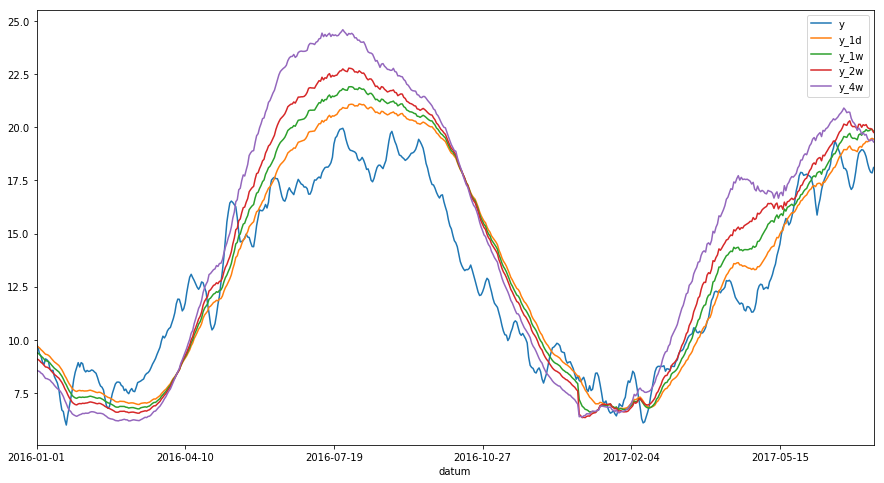

In [21]:
data.plot(x=['datum'], y=['y', 'y_1d', 'y_1w', 'y_2w', 'y_4w'], figsize=(15,8))

De volgende zaken vallen op

* de voorspelling loopt achter op de echte ontwikkelingen
* de voorspelling schiet ruim voorbij de werkelijke metingen
* hoe groter de voorspellingsruimte hoe hoger de afwijking 

Dit lijkt niet de meeste logische weg te zijn om te vervolgen

We proberen het anders met de vergelijking met KNMI data met dagelijkse temperatuur metingen van het in IJmuiden gelegen meetstation.

In [108]:
dateparser = lambda x: pd.datetime.strptime(x, '%Y%m%d')
knmi = pd.read_csv('data/knmi/etmgeg_240.txt', header=44, parse_dates=[1], date_parser=dateparser)
knmi.head()

,# STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,240,1951-01-01,188,77,87,195,18,41,24,,...,,,,7,90,98,6,73,20,NaN
1,240,1951-01-02,153,41,41,82,4,10,21,,...,,,,8,93,98,9,88,1,NaN
2,240,1951-01-03,203,15,21,51,24,0,3,,...,,,,6,94,100,21,83,12,NaN
3,240,1951-01-04,193,77,77,103,15,51,1,,...,,,,7,94,97,12,89,8,NaN
4,240,1951-01-05,207,82,87,144,21,36,24,,...,,,,8,95,100,5,89,14,NaN


Toon de temperatuur op dezelfde periode als de metingen van de Haarlemmerweg

In [109]:
selectie = knmi[['YYYYMMDD', 'TG']]
selectie = selectie[selectie['YYYYMMDD']>=df['datum'].iloc[0]]
selectie = selectie[selectie['YYYYMMDD']<=df['datum'].iloc[-1]]

In [110]:
selectie['TG']*=0.1
selectie['T'] = df['3H325WT01TT001'].values
selectie.head()

,YYYYMMDD,TG,T
23376,2015-01-01,3.5,7.804
23377,2015-01-02,7.6,8.087
23378,2015-01-03,4.6,8.294
23379,2015-01-04,3.5,8.370
23380,2015-01-05,2.9,8.204


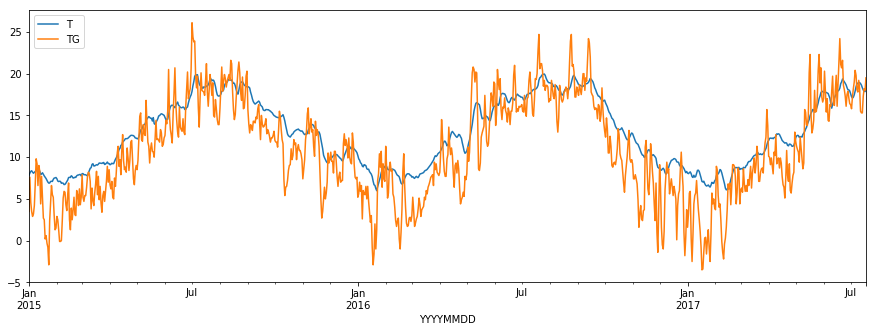

In [111]:
selectie.plot(x=['YYYYMMDD'], y=['T', 'TG'], figsize=(15,5))

Experiment, we gebruiken de KNMI data in FBProphet om te kijken of we dan een mooie fit krijgen.

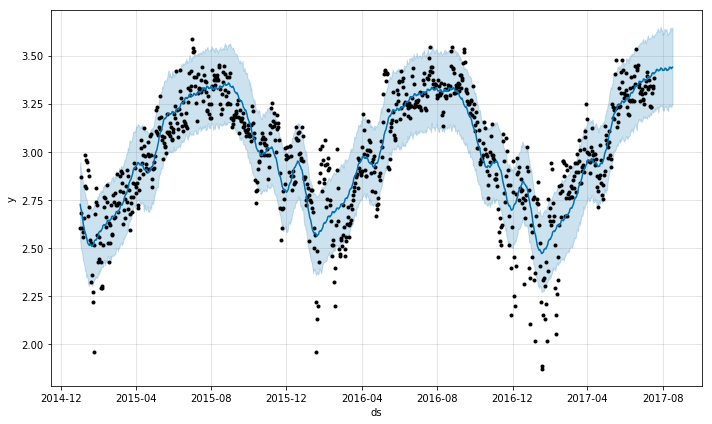

In [143]:
df_knmi = pd.DataFrame()
df_knmi['ds'] = selectie['YYYYMMDD']
df_knmi['y'] = np.log(selectie['TG']+10.)
model = Prophet()
model.fit(df_knmi)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
_ = model.plot(forecast)

In [144]:
selectie['Tf'] = forecast['yhat'].iloc[0:-30].values
selectie['Tf_upper'] = forecast['yhat_upper'].iloc[0:-30].values
selectie['Tf'] = np.exp(selectie['Tf'])
selectie['Tf'] -= 10.
selectie['Tf_upper'] = np.exp(selectie['Tf_upper'])
selectie['Tf_upper'] -= 10.

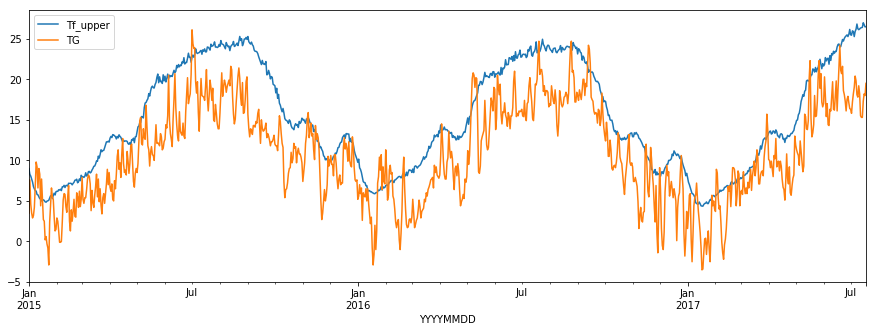

In [146]:
selectie.plot(x=['YYYYMMDD'], y=['Tf_upper', 'TG'], figsize=(15,5))

Dit is interessant.. de y_upper gebaseerd op de dagwaarden uit het meetstation Schiphol is een hele aardige indicator van de maximum temperatuur die bereikt kan worden!